##Augamentation

In [0]:
import numpy as np
import glob
import progressbar
from skimage.io import imread
import skimage

img_size = 100
n_aug = 10

def rotate(img, face_points, angle):
    theta = np.radians(angle)
    c, s = np.cos(theta), np.sin(theta)
    R = (np.array(((c,-s), (s, c)))).astype('float32')
    img1 = skimage.transform.rotate(img, angle).astype('float32')
    new_face_points = face_points.astype('float32')
    
    d_y, d_x, _ = img1.shape
    d_y /= 2
    d_x /= 2
    
    new_face_points[::2] -= d_y
    new_face_points[1::2] -= d_x
    
    for i, x in enumerate(range(0, new_face_points.size, 2)):
        new_face_points[x:x+2] = np.dot(new_face_points[x:x+2], R)
        
    new_face_points[::2] += d_y
    new_face_points[1::2] += d_x
        
    return (brightness(img1), new_face_points)
    
def mirror(img, face_points):
    # и ЭТО переписать бы
    d_y, d_x, _ = img.shape
    d_y /= 2
    d_x /= 2
    new_face_points = face_points.astype('float32')
    new_face_points[::2] -= d_y
    new_face_points[::2] *= -1
    new_face_points[::2] += d_y
    img1 = img[:, ::-1]
    
    new_face_points[0], new_face_points[6] = new_face_points[6], new_face_points[0]
    new_face_points[1], new_face_points[7] = new_face_points[7], new_face_points[1]
    
    new_face_points[18], new_face_points[8] = new_face_points[8], new_face_points[18]
    new_face_points[19], new_face_points[9] = new_face_points[9], new_face_points[19]
    
    new_face_points[10], new_face_points[16] = new_face_points[16], new_face_points[10]
    new_face_points[11], new_face_points[17] = new_face_points[17], new_face_points[11]
    
    new_face_points[2], new_face_points[4] = new_face_points[4], new_face_points[2]
    new_face_points[3], new_face_points[5] = new_face_points[5], new_face_points[3]
    
    new_face_points[12], new_face_points[14] = new_face_points[14], new_face_points[12]
    new_face_points[13], new_face_points[15] = new_face_points[15], new_face_points[13]
    
    new_face_points[22], new_face_points[26] = new_face_points[26], new_face_points[22]
    new_face_points[23], new_face_points[27] = new_face_points[27], new_face_points[23] 
    
    return (brightness(img1), new_face_points)


def augmentation(img, face_points, X_data, y_data, base, n):
    X_data[n * base][:,:,0], y_data[n * base] = (brightness(img), face_points)
    X_data[n * base + 1][:,:,0], y_data[n * base + 1] = mirror(img, face_points)
    m_img, m_points = img[:,::-1], y_data[n * base + 1]
    k = 2

    for i in range(1, n//4 + 1):
        X_data[n * base + k][:,:,0], y_data[n * base + k] = rotate(img, face_points, -5 * i)
        X_data[n * base + k + 1][:,:,0], y_data[n * base + k + 1] = rotate(img, face_points, 5 * i)
        X_data[n * base + k + 2][:,:,0], y_data[n * base + k + 2] = rotate(m_img, m_points, -5 * i)
        X_data[n * base + k + 3][:,:,0], y_data[n * base + k + 3] = rotate(m_img, m_points, 5 * i)
        k += 4

def download(train_gt, train_img_dir, fast_train=False):
    #TODO будет время, перепиши ЭТО
    X_data = np.zeros((n_aug * int(0.8 * len(train_gt)), img_size, img_size, 1))
    y_data = np.zeros((n_aug * int(0.8 * len(train_gt)), 28)).astype(float)

    X_val = np.zeros((int(0.2 * len(train_gt)), img_size, img_size, 1))
    y_val = np.zeros((int(0.2 * len(train_gt)), 28)).astype(float)

    files = glob.glob(join(train_img_dir, '*.jpg'))
    num = 0
    k = 0
    
    bar = progressbar.ProgressBar(maxval=6000).start()
    for name in files:
        if num >= int(0.8 * len(train_gt)):
            i = name[-9:len(name)]
            in_img = imread(name, as_gray=True)
            X_val[k][:,:,0] = brightness(skimage.transform.resize(in_img, (img_size, img_size, 1)))
            face_points = np.array(train_gt[i])
            face_points[::2] *= (img_size / in_img.shape[1])
            face_points[1::2] *= (img_size / in_img.shape[0])
            y_val[k] = face_points
            num += 1
            k += 1
            continue

        i = name[-9:len(name)]
        in_img = imread(name, as_gray=True)    
        img = skimage.transform.resize(in_img, (img_size, img_size, 1))
        face_points = np.array(train_gt[i])
        face_points[::2] *= (img_size / in_img.shape[1])
        face_points[1::2] *= (img_size / in_img.shape[0])
        augmentation(img, face_points, X_data, y_data, num, n_aug)
        
        num += 1
        bar.update(num)
        
    bar.finish()
    return (X_data, y_data, X_val, y_val)

from os.path import join

def read_csv(filename):
    res = {}
    with open(filename) as fhandle:
        next(fhandle)
        for line in fhandle:
            parts = line.rstrip('\n').split(',')
            coords = np.array([float(x) for x in parts[1:]], dtype='float64')
            res[parts[0]] = coords
    return res


from google.colab import drive
drive.mount('/content/gdrive')
!cp /content/gdrive/'My Drive'/public_tests.zip . 
!unzip -q public_tests.zip -d tests

data_dir = 'tests/00_test_img_input'
train_dir = join(data_dir, 'train')
test_dir = join(data_dir, 'test')
train_gt = read_csv(join(train_dir, 'gt.csv'))
train_img_dir = join(train_dir, 'images')
X_data, y_data, X_val, y_val = download(train_gt, train_img_dir)

Mounted at /content/gdrive
replace tests/00_test_img_gt/gt.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


100% (6000 of 6000) |####################| Elapsed Time: 0:06:44 Time:  0:06:44


##Нормализация

In [0]:
X_data /= 255.0
X_val /= 255.0

np.save('gdrive/My Drive/detect/60X_train', X_data)
np.save('gdrive/My Drive/detect/60y_train', y_data)
np.save('gdrive/My Drive/detect/60X_val', X_val)
np.save('gdrive/My Drive/detect/60y_val', y_val)

111.72739566154816 66.95035634873943


##Загрузка датасета

In [4]:
import numpy as np
from google.colab import drive
drive.mount('/content/gdrive')


X_data = np.load('gdrive/My Drive/detect/X_train.npy')
y_data = np.load('gdrive/My Drive/detect/y_train.npy')
X_val = np.load('gdrive/My Drive/detect/X_val.npy')
y_val = np.load('gdrive/My Drive/detect/y_val.npy')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##Проверка данных

Проверка тренировочной выборки:


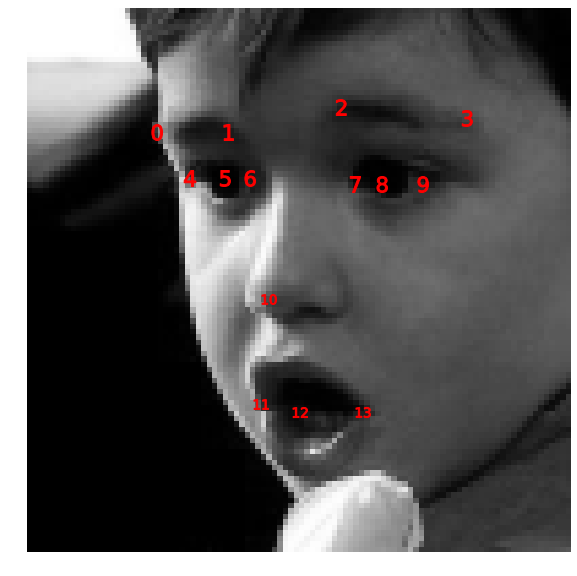

Проверка валидационной выборки:


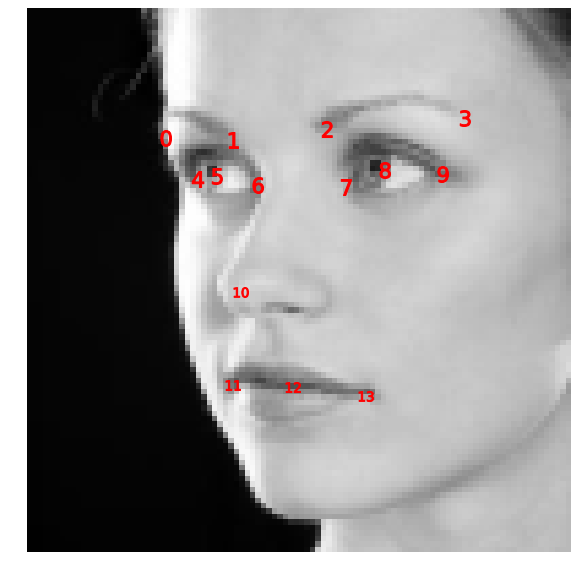

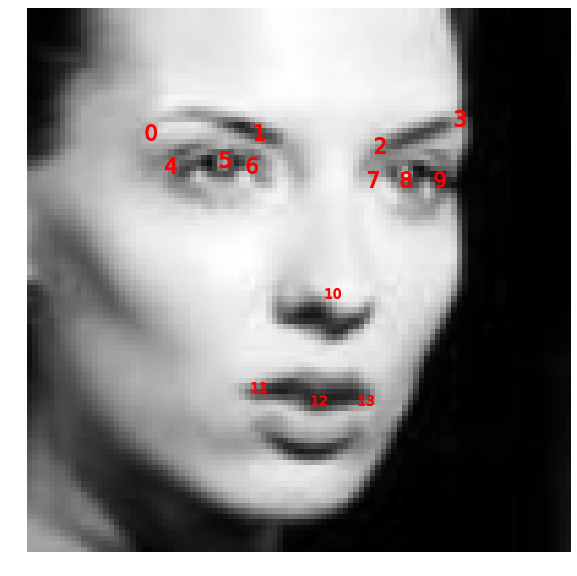

In [0]:
img_size = 100

def show_points(image, face_points):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(15, 10))
    plt.imshow(image, cmap = 'gray')
    plt.axis('off')
    for i, x in enumerate(range(0, face_points.size, 2)):
        plt.scatter(face_points[x], face_points[x + 1], s=256,
                    marker='$' + str(i) + '$', edgecolors='face', color='r')
    plt.show()

print('Проверка тренировочной выборки:')
for i in range(100, 101):
    img = (X_data[i])
    show_points(img[:,:,0], y_data[i])

print('Проверка валидационной выборки:')
for i in range(0, 2):
    img = (X_val[i])
    show_points(img[:, :, 0], y_val[i])

##Архитектура нейронной сети

In [0]:
img_size = 100

import keras
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.local import LocallyConnected2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import regularizers

model = Sequential()
model.add(Conv2D(20, kernel_size=(5, 5), activation='relu', 
                 input_shape=(img_size, img_size, 1),
                 kernel_initializer='he_uniform'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(40, kernel_size=(5, 5), activation='relu',
                 kernel_initializer='he_uniform'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(60, kernel_size=(3, 3), activation='relu',
                 kernel_initializer='he_uniform'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(LocallyConnected2D(80, (3, 3), activation='relu',
                 kernel_initializer='he_uniform'))


model.add(Flatten())


model.add(Dropout(0.2))
model.add(Dense(128, activation='relu',kernel_initializer='he_uniform'))
model.add(Dropout(0.4))



model.add(Dense(28, activation='relu',
                kernel_initializer='he_uniform'))

model.compile(loss="mse", optimizer="adam", metrics=['mae'])

model.summary()










Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 20)        520       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 20)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 20)        80        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 40)        20040     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 40)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 22, 22, 40)        160   

##Обучение

In [24]:
from tensorflow.keras.models import load_model
import numpy as np
from google.colab import drive
from tensorflow.keras.callbacks import EarlyStopping
drive.mount('/content/gdrive')

batch_size = 200
epochs = 100

model = load_model('gdrive/My Drive/detect/pyatorochka.hdf5')
history= model.fit(X_data, y_data,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val, y_val),
          shuffle=True)

model.save('gdrive/My Drive/detect/p11owerful_model.hdf5')
    

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Train on 48000 samples, validate on 1200 samples


##Визуализация обучения

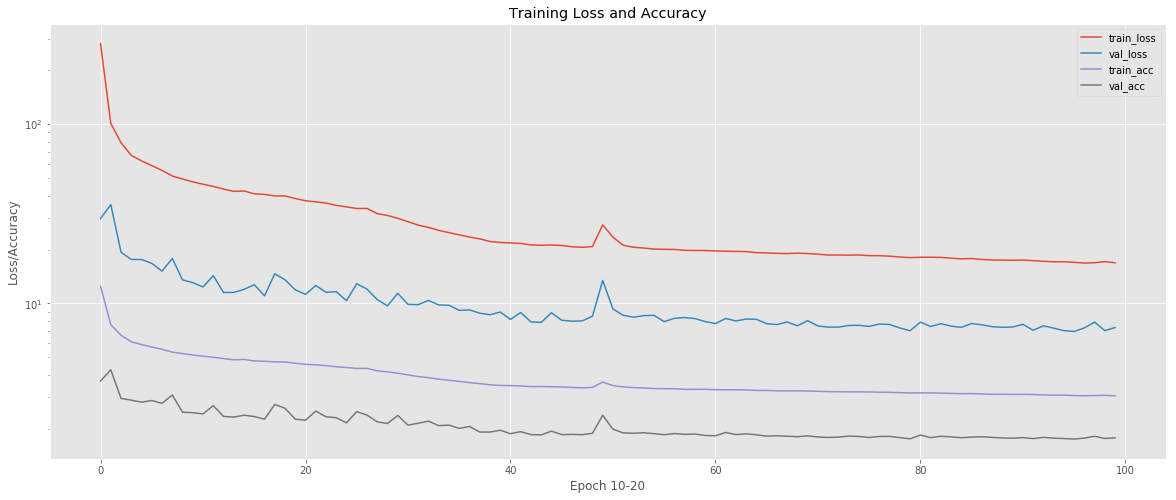

In [0]:
def save_statistic(model_history):
    from matplotlib import pyplot as plt
    import numpy as np

    FIGURE_SIZE = (20, 8)      
    FILE_NAME = 'gdrive/My Drive/detect/history.png'  
    N = np.arange(len(model_history.epoch))

    plt.style.use('ggplot')
    fig, axes = plt.subplots(figsize=FIGURE_SIZE)
    axes.semilogy(N, model_history.history["loss"], label="train_loss")
    axes.semilogy(N, model_history.history["val_loss"], label="val_loss")
    axes.semilogy(N, model_history.history["mean_absolute_error"], label="train_acc")
    axes.semilogy(N, model_history.history["val_mean_absolute_error"], label="val_acc")
    axes.set_title("Training Loss and Accuracy")
    axes.set_ylabel("Loss/Accuracy")
    axes.set_xlabel("Epoch 10-20")
    axes.legend()
    #fig.savefig(fname=FILE_NAME)

save_statistic(history)
model.save('gdrive/My Drive/detect/kek1.hdf5')

##Проверка модели

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[[20.942085 16.957855 42.727123 20.821396 67.04104  23.601381 86.71753
  25.452791 24.075298 28.13247  32.320908 29.363613 40.039574 31.389624
  64.894394 34.11654  72.34511  34.022167 80.411835 34.940907 50.003296
  56.190384 29.98312  65.05319  46.161095 70.25278  61.64576  68.964195]]


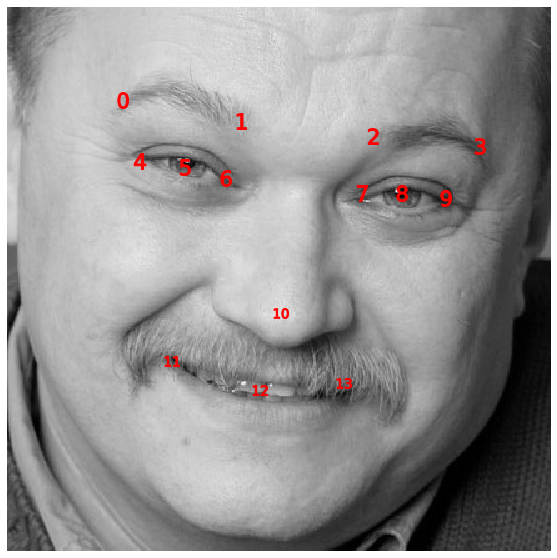

In [27]:
from skimage.io import imread
import skimage
import numpy as np
from google.colab import drive
drive.mount('/content/gdrive')


from google.colab import drive
drive.mount('/content/gdrive')
# !cp /content/gdrive/'My Drive'/crash_test.zip . 
# !unzip -q crash_test.zip -d mini

in_img = imread('mini/crash_test/mash2.jpg', as_gray=True)


img_size = 100
img = skimage.transform.resize(in_img, (img_size, img_size, 1))


def show_points(image, face_points):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(15, 10))
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    for i, x in enumerate(range(0, face_points.size, 2)):
        plt.scatter(face_points[x], face_points[x + 1], s=256,
                    marker='$' + str(i) + '$', edgecolors='face', color='r')
    plt.show()

test = np.zeros([1, img_size, img_size, 1])

test[0] = img


face_points = model.predict(test)
print(face_points)


face_points[0, ::2] *= (in_img.shape[1] / img_size)
face_points[0, 1::2] *= (in_img.shape[0] / img_size)


show_points(in_img, face_points[0])